In [1]:
# necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [21]:
# necessary parameters
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
batch_size = 512
epochs = 20
learning_rate = 1e-4

In [22]:
# Define a fully connected autoencoder with three encoder and three decoder layers
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(Autoencoder, self).__init__()
        # encoder with 3 layers
        self.encoder = nn.Sequential(


            nn.Linear(input_size, hidden_sizes[0]),#input layer
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),#hidden_layer1
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU()
        )
        # decoder with 3 layers
        self.decoder = nn.Sequential(
            nn.Linear(hidden_sizes[2], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Define constants
input_size = 32 * 32 * 3  # Size of SVHN images
hidden_sizes = [256, 128, 64]  # Adjust as needed

# hidden_sizes = [256, 128, 64] indicates a neural network with three hidden layers
# The first hidden layer has 256 neurons, the second hidden layer has 128 neurons, and the third hidden layer has 64 neurons

In [3]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#summary of model autoencoer
from torchsummary import summary
# Create an instance of the Autoencoder
autoencoder_instance = Autoencoder(input_size, hidden_sizes)

# Use summary to display the model architecture
summary(autoencoder_instance.cuda(), (input_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         786,688
              ReLU-2                  [-1, 256]               0
            Linear-3                  [-1, 128]          32,896
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                  [-1, 128]           8,320
              ReLU-8                  [-1, 128]               0
            Linear-9                  [-1, 256]          33,024
             ReLU-10                  [-1, 256]               0
           Linear-11                 [-1, 3072]         789,504
          Sigmoid-12                 [-1, 3072]               0
Total params: 1,658,688
Trainable params: 1,658,688
Non-trainable params: 0
---------------------------

In [5]:
# Load SVHN dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)


100%|██████████| 182040794/182040794 [00:04<00:00, 41186530.18it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
j=0
for i in train_dataset:
  print(i)
  j=j+1
  if j==2:
    break;
train_dataset

(tensor([[[-0.7412, -0.8824, -0.8824,  ..., -0.4353, -0.3569, -0.3020],
         [-0.7804, -0.8902, -0.8902,  ..., -0.6863, -0.4745, -0.3490],
         [-0.6863, -0.8588, -0.8745,  ..., -0.8196, -0.7255, -0.4353],
         ...,
         [-0.3255, -0.3176, -0.3569,  ..., -0.1843, -0.1843, -0.1922],
         [-0.3412, -0.3255, -0.3569,  ..., -0.1373, -0.1686, -0.1686],
         [-0.3333, -0.3020, -0.3333,  ..., -0.1294, -0.1451, -0.1922]],

        [[-0.7647, -0.8196, -0.8667,  ..., -0.4902, -0.3961, -0.3804],
         [-0.6941, -0.8039, -0.8431,  ..., -0.6941, -0.5451, -0.3882],
         [-0.6784, -0.8353, -0.8667,  ..., -0.7725, -0.6706, -0.4588],
         ...,
         [-0.3647, -0.3569, -0.3804,  ..., -0.1843, -0.1765, -0.1765],
         [-0.3255, -0.3804, -0.4039,  ..., -0.1922, -0.1765, -0.1843],
         [-0.3098, -0.3569, -0.3804,  ..., -0.1843, -0.1765, -0.1686]],

        [[-0.7020, -0.8510, -0.8510,  ..., -0.5608, -0.5529, -0.5373],
         [-0.7255, -0.8275, -0.8667,  ..., -

Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:
# Initialize the autoencoder
autoencoder = Autoencoder(input_size, hidden_sizes)

In [24]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

In [25]:
# Training the autoencoder without sparsity constraint
num_epochs = 20
loss_list=[]
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)

        # Forward pass
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the autoencoder without sparsity constraint



Epoch [1/20], Loss: 0.1358
Epoch [2/20], Loss: 0.1185
Epoch [3/20], Loss: 0.0900
Epoch [4/20], Loss: 0.1241
Epoch [5/20], Loss: 0.1169
Epoch [6/20], Loss: 0.0525
Epoch [7/20], Loss: 0.0432
Epoch [8/20], Loss: 0.1011
Epoch [9/20], Loss: 0.0763
Epoch [10/20], Loss: 0.1247
Epoch [11/20], Loss: 0.1137
Epoch [12/20], Loss: 0.1348
Epoch [13/20], Loss: 0.1144
Epoch [14/20], Loss: 0.0877
Epoch [15/20], Loss: 0.1215
Epoch [16/20], Loss: 0.1589
Epoch [17/20], Loss: 0.0877
Epoch [18/20], Loss: 0.0873
Epoch [19/20], Loss: 0.1324
Epoch [20/20], Loss: 0.0875


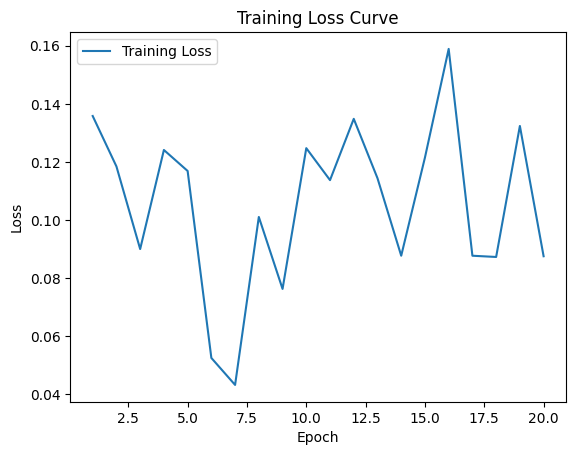

In [26]:
# Visualize the loss curve
plt.plot(range(1, num_epochs + 1), loss_list, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Using downloaded and verified file: ./data/test_32x32.mat


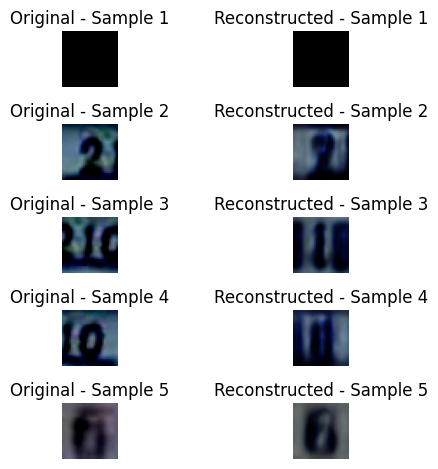

In [27]:
# Evaluate the autoencoder without sparsity constraint
autoencoder.eval()

# Create a test DataLoader
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Define a function to visualize original and reconstructed images
def visualize_reconstructions(model, data_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)

            # Forward pass
            outputs = model(inputs)

            # Convert to NumPy arrays
            inputs_np = inputs.cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            # Visualize a few samples
            for j in range(num_samples):
                original_img = np.transpose(inputs_np[j].reshape(3, 32, 32), (1, 2, 0))
                reconstructed_img = np.transpose(outputs_np[j].reshape(3, 32, 32), (1, 2, 0))

                # Plot original and reconstructed images side by side
                plt.subplot(num_samples, 2, 2 * j + 1)
                plt.imshow(original_img)
                plt.title(f'Original - Sample {j + 1}')
                plt.axis('off')

                plt.subplot(num_samples, 2, 2 * j + 2)
                plt.imshow(reconstructed_img)
                plt.title(f'Reconstructed - Sample {j + 1}')
                plt.axis('off')

            break  # Only visualize the first batch

# Visualize reconstructed images
visualize_reconstructions(autoencoder, test_loader, num_samples=5)
plt.tight_layout()
plt.show()



>SparseAutoencoder



In [12]:
# Extend the autoencoder by incorporating a sparsity constraint
class SparseAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_sizes, sparsity_factor):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_sizes[2], hidden_sizes[1]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[1], hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], input_size),
            nn.Sigmoid()
        )
        self.sparsity_factor = sparsity_factor

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def compute_sparsity_penalty(self, hidden):
        avg_activation = torch.mean(hidden, dim=0)
        sparsity_penalty = self.sparsity_factor * torch.sum((1 - avg_activation) ** 2)
        return sparsity_penalty





In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)

# # Define constants
# sparsity_factor = 0.1  # Adjust as needed

# Initialize the autoencoder with sparsity constraint
hidden_sizes_sparse = [512, 256, 128]  # Adjust as needed
sparsity_factor_sparse = 0.05  # Adjust as needed

# Initialize the autoencoder with sparsity constraint
sparse_autoencoder = SparseAutoencoder(input_size, hidden_sizes, sparsity_factor_sparse)

# Define loss function and optimizer with sparsity penalty
criterion = nn.MSELoss()
optimizer = optim.Adam(sparse_autoencoder.parameters(), lr=0.0001)


Epoch [1/20], Loss: 94.0024, Sparsity Penalty: 93.8774
Epoch [2/20], Loss: 51.4524, Sparsity Penalty: 51.2560
Epoch [3/20], Loss: 22.9039, Sparsity Penalty: 22.7686
Epoch [4/20], Loss: 6.8330, Sparsity Penalty: 6.7365
Epoch [5/20], Loss: 0.8615, Sparsity Penalty: 0.7365
Epoch [6/20], Loss: 0.1970, Sparsity Penalty: 0.0030
Epoch [7/20], Loss: 0.1288, Sparsity Penalty: 0.0000
Epoch [8/20], Loss: 0.1171, Sparsity Penalty: 0.0000
Epoch [9/20], Loss: 0.1106, Sparsity Penalty: 0.0000
Epoch [10/20], Loss: 0.1117, Sparsity Penalty: 0.0000
Epoch [11/20], Loss: 0.1647, Sparsity Penalty: 0.0000
Epoch [12/20], Loss: 0.1396, Sparsity Penalty: 0.0000
Epoch [13/20], Loss: 0.1278, Sparsity Penalty: 0.0000
Epoch [14/20], Loss: 0.1254, Sparsity Penalty: 0.0000
Epoch [15/20], Loss: 0.1362, Sparsity Penalty: 0.0000
Epoch [16/20], Loss: 0.0827, Sparsity Penalty: 0.0000
Epoch [17/20], Loss: 0.0765, Sparsity Penalty: 0.0000
Epoch [18/20], Loss: 0.1082, Sparsity Penalty: 0.0000
Epoch [19/20], Loss: 0.1157, Sp

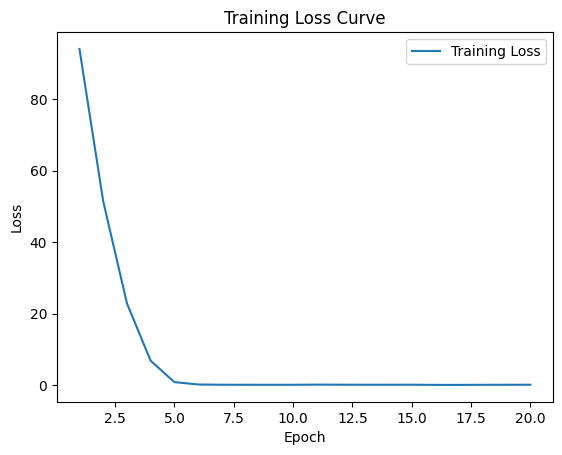

In [14]:
# Training the autoencoder with sparsity constraint
num_epochs = 20
loss_list=[]
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)

        # Forward pass
        outputs = sparse_autoencoder(inputs)
        sparsity_penalty = sparse_autoencoder.compute_sparsity_penalty(sparse_autoencoder.encoder[0].weight)
        loss = criterion(outputs, inputs) + sparsity_penalty

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_list.append(loss.item())
    # Print progress
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Sparsity Penalty: {sparsity_penalty.item():.4f}')

# Evaluate the autoencoder with sparsity constraint
# You can visualize reconstructed images and compare them with the original ones
# Visualize the loss curve
plt.plot(range(1, num_epochs + 1), loss_list, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Using downloaded and verified file: ./data/test_32x32.mat


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


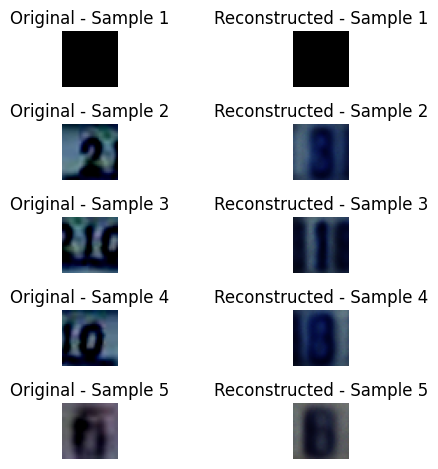

In [23]:
 # Evaluate the autoencoder with sparsity constraint
sparse_autoencoder.eval()

# Create a test DataLoader
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Define a function to visualize original and reconstructed images
def visualize_reconstructions(model, data_loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            inputs, _ = data
            inputs = inputs.view(inputs.size(0), -1)

            # Forward pass
            outputs = model(inputs)

            # Convert to NumPy arrays
            inputs_np = inputs.cpu().numpy()
            outputs_np = outputs.cpu().numpy()

            # Visualize a few samples
            for j in range(num_samples):
                original_img = np.transpose(inputs_np[j].reshape(3, 32, 32), (1, 2, 0))
                reconstructed_img = np.transpose(outputs_np[j].reshape(3, 32, 32), (1, 2, 0))

                # Plot original and reconstructed images side by side
                plt.subplot(num_samples, 2, 2 * j + 1)
                plt.imshow(original_img)
                plt.title(f'Original - Sample {j + 1}')
                plt.axis('off')

                plt.subplot(num_samples, 2, 2 * j + 2)
                plt.imshow(reconstructed_img)
                plt.title(f'Reconstructed - Sample {j + 1}')
                plt.axis('off')

            break  # Only visualize the first batch

# Visualize reconstructed images
visualize_reconstructions(sparse_autoencoder, test_loader, num_samples=5)
plt.tight_layout()
plt.show()